In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy.stats import pearsonr
#from scipy.spatial.distance import correlation

In [3]:
def get_stimulus_data(stim_f):
    stimdata = pd.read_csv(stim_f)
    testdata= stimdata[stimdata['trial_type'] == 'test']

    temp = pd.DataFrame(columns=['stimulus', 'r1', 'r2'])
    temp[['stimulus', 'r1', 'r2']] = testdata['stimulus'].str.rsplit('_', expand= True)
    
    for t in temp.index:
        if temp['r2'][t] is None:
            testdata['stimulus'][t] = temp['stimulus'][t]
        else: 
            testdata['stimulus'][t] = temp['stimulus'][t]+temp['r1'][t]
    #testdata= testdata.drop(['session', 'run'], axis=1)
    #testdata_stimulusIndex = testdata.set_index('stimulus')
    return testdata

In [58]:

' a function for zeroing the value close to zero '

def limtozero(x):

    """
    zero the value close to zero
    Parameters
    ----------
    x : float
    Returns
    -------
    0
    """

    if x < 1e-15:
        x = 0

    return x
def compute_rdm2(data, method="correlation", abs = False):
  print("\nComputing RDM")
  cons = len(data)
  rdm = np.zeros([cons, cons], dtype=np.float64)
  
  '''
  # judge whether numbers of trials of different conditions are same
  if len(set(n_subs)) != 1:
      return None

  # assignment
  # save the data for each subject under each condition, average the trials
  data = np.average(bhv_data, axis=2)
  '''
  # calculate the values in RDM
  for i in range(cons):
      for j in range(cons):
          if method == 'correlation':
              # calculate the Pearson Coefficient
              r = pearsonr(data[i], data[j])[0]
              # calculate the dissimilarity
              
              if abs == True:
                  rdm[i, j] = limtozero(1 - np.abs(r))
              else:
                  rdm[i, j] = limtozero(1 - r)
                  #rdm[i, j] = (1 - r)
                  
          elif method == 'euclidean':
              rdm[i, j] = np.linalg.norm(data[i]-data[j])
  if method == 'euclidean':
      max = np.max(rdm)
      min = np.min(rdm)
      rdm = (rdm-min)/(max-min)

  print("\nRDM computing finished!")
  return rdm

In [25]:

' a function for plotting the RDM '

def plot_rdm(rdm, percentile=False, rescale=False, lim=[0, 1], conditions=None, con_fontsize=16, cmap=None, title=None,
             title_fontsize=16):

    """
    Plot the RDM
    Parameters
    ----------
    rdm : array or list [n_cons, n_cons]
        A representational dissimilarity matrix.
    percentile : bool True or False. Default is False.
        Rescale the values in RDM or not by displaying the percentile.
    rescale : bool True or False. Default is False.
        Rescale the values in RDM or not.
        Here, the maximum-minimum method is used to rescale the values except for the
        values on the diagnal.
    lim : array or list [min, max]. Default is [0, 1].
        The corrs view lims.
    conditions : string-array or string-list. Default is None.
        The labels of the conditions for plotting.
        conditions should contain n_cons strings, If conditions=None, the labels of conditions will be invisible.
    con_fontsize : int or float. Default is 12.
        The fontsize of the labels of the conditions for plotting.
    cmap : matplotlib colormap. Default is None.
        The colormap for RDM.
        If cmap=None, the ccolormap will be 'jet'.
    title : string-array. Default is None.
        The title of the figure.
    title_fontsize : int or float. Default is 16.
        The fontsize of the title.
    """

    if len(np.shape(rdm)) != 2 or np.shape(rdm)[0] != np.shape(rdm)[1]:

        return "Invalid input!"

    # get the number of conditions
    cons = rdm.shape[0]

    crdm = copy.deepcopy(rdm)

    # if cons=2, the RDM cannot be plotted.
    if cons == 2:
        print("The shape of RDM cannot be 2*2.")

        return None
   
    # determine if it's a square
    a, b = np.shape(crdm)
    if a != b:
        return None

    if percentile == True:

        v = np.zeros([cons * cons, 2], dtype=float)
        for i in range(cons):
            for j in range(cons):
                v[i * cons + j, 0] = crdm[i, j]

        index = np.argsort(v[:, 0])
        m = 0
        for i in range(cons * cons):
            if i > 0:
                if v[index[i], 0] > v[index[i - 1], 0]:
                    m = m + 1
                v[index[i], 1] = m

        v[:, 0] = v[:, 1] * 100 / m

        for i in range(cons):
            for j in range(cons):
                crdm[i, j] = v[i * cons + j, 0]

        if cmap == None:
            plt.imshow(crdm, extent=(0, 1, 0, 1), cmap=plt.cm.jet, clim=(0, 100))
        else:
            plt.imshow(crdm, extent=(0, 1, 0, 1), cmap=cmap, clim=(0, 100))

    # rescale the RDM
    elif rescale == True:

        # flatten the RDM
        vrdm = np.reshape(rdm, [cons * cons])
        # array -> set -> list
        svrdm = set(vrdm)
        lvrdm = list(svrdm)
        lvrdm.sort()

        # get max & min
        maxvalue = lvrdm[-1]
        minvalue = lvrdm[1]

        # rescale
        if maxvalue != minvalue:

            for i in range(cons):
                for j in range(cons):

                    # not on the diagnal
                    if i != j:
                        crdm[i, j] = float((crdm[i, j] - minvalue) / (maxvalue - minvalue))

        # plot the RDM
        min = lim[0]
        max = lim[1]
        if cmap == None:
            plt.imshow(crdm, extent=(0, 1, 0, 1), cmap=plt.cm.jet, clim=(min, max))
        else:
            plt.imshow(crdm, extent=(0, 1, 0, 1), cmap=cmap, clim=(min, max))

    else:
        # plot the RDM
        min = lim[0]
        max = lim[1]
        if cmap == None:
            plt.imshow(crdm, extent=(0, 1, 0, 1), cmap=plt.cm.jet, clim=(min, max))
        else:
            plt.imshow(crdm, extent=(0, 1, 0, 1), cmap=cmap, clim=(min, max))

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=16)
    font = {'size': 18}

    if percentile == True:
        cb.set_label("Dissimilarity (percentile)", fontdict=font)
    elif rescale == True:
        cb.set_label("Dissimilarity (Rescaling)", fontdict=font)
    else:
        cb.set_label("Dissimilarity", fontdict=font)

    if conditions.any() is not None:
        print("1")
        step = float(1 / cons)
        x = np.arange(0.5 * step, 1 + 0.5 * step, step)
        y = np.arange(1 - 0.5 * step, -0.5 * step, -step)
        plt.xticks(x, conditions, fontsize=con_fontsize, rotation=90, ha="right")
        plt.yticks(y, conditions, fontsize=con_fontsize)
    else:
        plt.axis("off")

    plt.title(title, fontsize=title_fontsize)

    plt.show()

    return 0

In [ ]:

response_data_1 = np.load(r"C:\Users\rogal\Downloads\betas_csv_testset\betas_csv_testset\sub-01_TestResponsesIT.npy")
response_data_2 = np.load(r"C:\Users\rogal\Downloads\betas_csv_testset\betas_csv_testset\sub-02_TestResponsesIT.npy")
response_data_3 = np.load(r"C:\Users\rogal\Downloads\betas_csv_testset\betas_csv_testset\sub-03_TestResponsesIT.npy")

meta_data_1 = get_stimulus_data(r"C:\Users\rogal\Downloads\betas_csv_testset\betas_csv_testset\sub-01_StimulusMetadataTestset.csv")
meta_data_2 = get_stimulus_data(r"C:\Users\rogal\Downloads\betas_csv_testset\betas_csv_testset\sub-02_StimulusMetadataTestset.csv")
meta_data_3 = get_stimulus_data(r"C:\Users\rogal\Downloads\betas_csv_testset\betas_csv_testset\sub-03_StimulusMetadataTestset.csv")

df_response_data = pd.DataFrame(columns= ['data'])
li = []
for i in response_data_1:
    li.append(i)
for i in response_data_2:
    li.append(i)
for i in response_data_3:
    li.append(i)
df_response_data = df_response_data.assign(data = li)
m_d = [meta_data_1, meta_data_2, meta_data_3]
meta_data = pd.concat(m_d)

In [65]:
full_data = pd.merge(meta_data, df_response_data, left_index = True, right_index = True)
reduced_data = full_data.drop(["Unnamed: 0", "session", "run", "subject_id", "trial_id", "trial_type"], axis =1)

reduced_data_average = reduced_data.groupby(['stimulus']).mean().reset_index()# apply(lambda x: np.average(x))#

In [67]:
#value_map = {'boa': 0, 'alligator': 1, 'cow': 2, 'beaver': 3, 'chipmunk': 4, 'butterfly': 5, 'chest1': 6, 'banana': 7, 'bean' : 8, 'bamboo': 9, 'cheese': 10, 
#             'cookie': 11, 'brownie': 12, 'ashtray': 13, 'beer' : 14, 'crank': 15, 'beachball': 16, 'brace' : 17, 'clipboard':18, 'axe': 19, 'candelabra': 20, 'coatrack': 21, 'bench': 22, 'bike': 23, 'blind': 24, 'bed': 25, 'altar': 26, 'bobsled': 27, 'bulldozer' : 28, 'boat' : 29}
#animacy distinction
def get_value(df): 
    distinction_list = []
    for stimulus in df['stimulus']:
        #animals: mammals
        if stimulus in ('cow', 'beaver', 'chipmunk', 'hippopotamus', 'horse',  'monkey', 'rabbit'):
            distinction_list.append(0)
        #animals: rest
        elif stimulus in ('boa', 'alligator', 'butterfly', 'chest1', 'dragonfly',  'iguana', 'starfish', 'wasp'):
            distinction_list.append(1)
        #fruits
        elif stimulus in ('banana', 'grape', 'mango', 'peach', 'pear'):
            distinction_list.append(2)
        #vrest of food
        elif stimulus in ('pumpkin', 'bean'):
            distinction_list.append(3)
        #rest of natural
        elif stimulus in ('bamboo', 'stalagmite', 'footprint', 'nest'):
            distinction_list.append(4)
        else:
            distinction_list.append(5)
    return distinction_list
df = reduced_data_average.assign(sort = lambda df: get_value(df))
df_sorted_animacy = df.sort_values('sort', ignore_index = True).drop('sort', axis='columns')

In [44]:
#indoors distinction
def get_value(df): 
    distinction_list = []
    for stimulus in df['stimulus']:
        #indoors
        if stimulus in ('altar', 'bed', 'cheese', 'cookie', 'brownie', 'donut', 'dough', 'guacamole', 'fudge', 'beer', 'clipboard', 'candelabra', 'coatrack', 'blind', 'crayon', 
                          'cufflink', 'drain', 'drawer', 'dress', 'earring', 'easel', 'grate', 'jam', 'jar', 'joystick', 'kimono', 'lasanga', 'lemonade', 'marshmallow', 'microscope', 'mosquitonet', 'mousetrap', 'pacifier', 'pan',
                          'piano', 'quill', 'ribbon', 'shredder', 'simcard', 'speaker', 'spoon', 't-shirt', 'tamale', 'television', 'typewriter', 'uniform', 'urinal', 'wallpaper', 'watch', 'whip', 'wig'):
            distinction_list.append(0)
        #outdoors
        else:
            distinction_list.append(1)
    return distinction_list
df = reduced_data_average.assign(sort = lambda df: get_value(df))
df_sorted_indoors = df.sort_values('sort', ignore_index = True).drop('sort', axis='columns')

In [ ]:
plt.figure(figsize=(25, 25))
questions_rdm = compute_rdm2(reduced_data_average['data'])

plot_rdm(questions_rdm, conditions = reduced_data_average['stimulus'], percentile = True)

RDM for animacy distinction


Computing RDM

RDM computing finished!
1


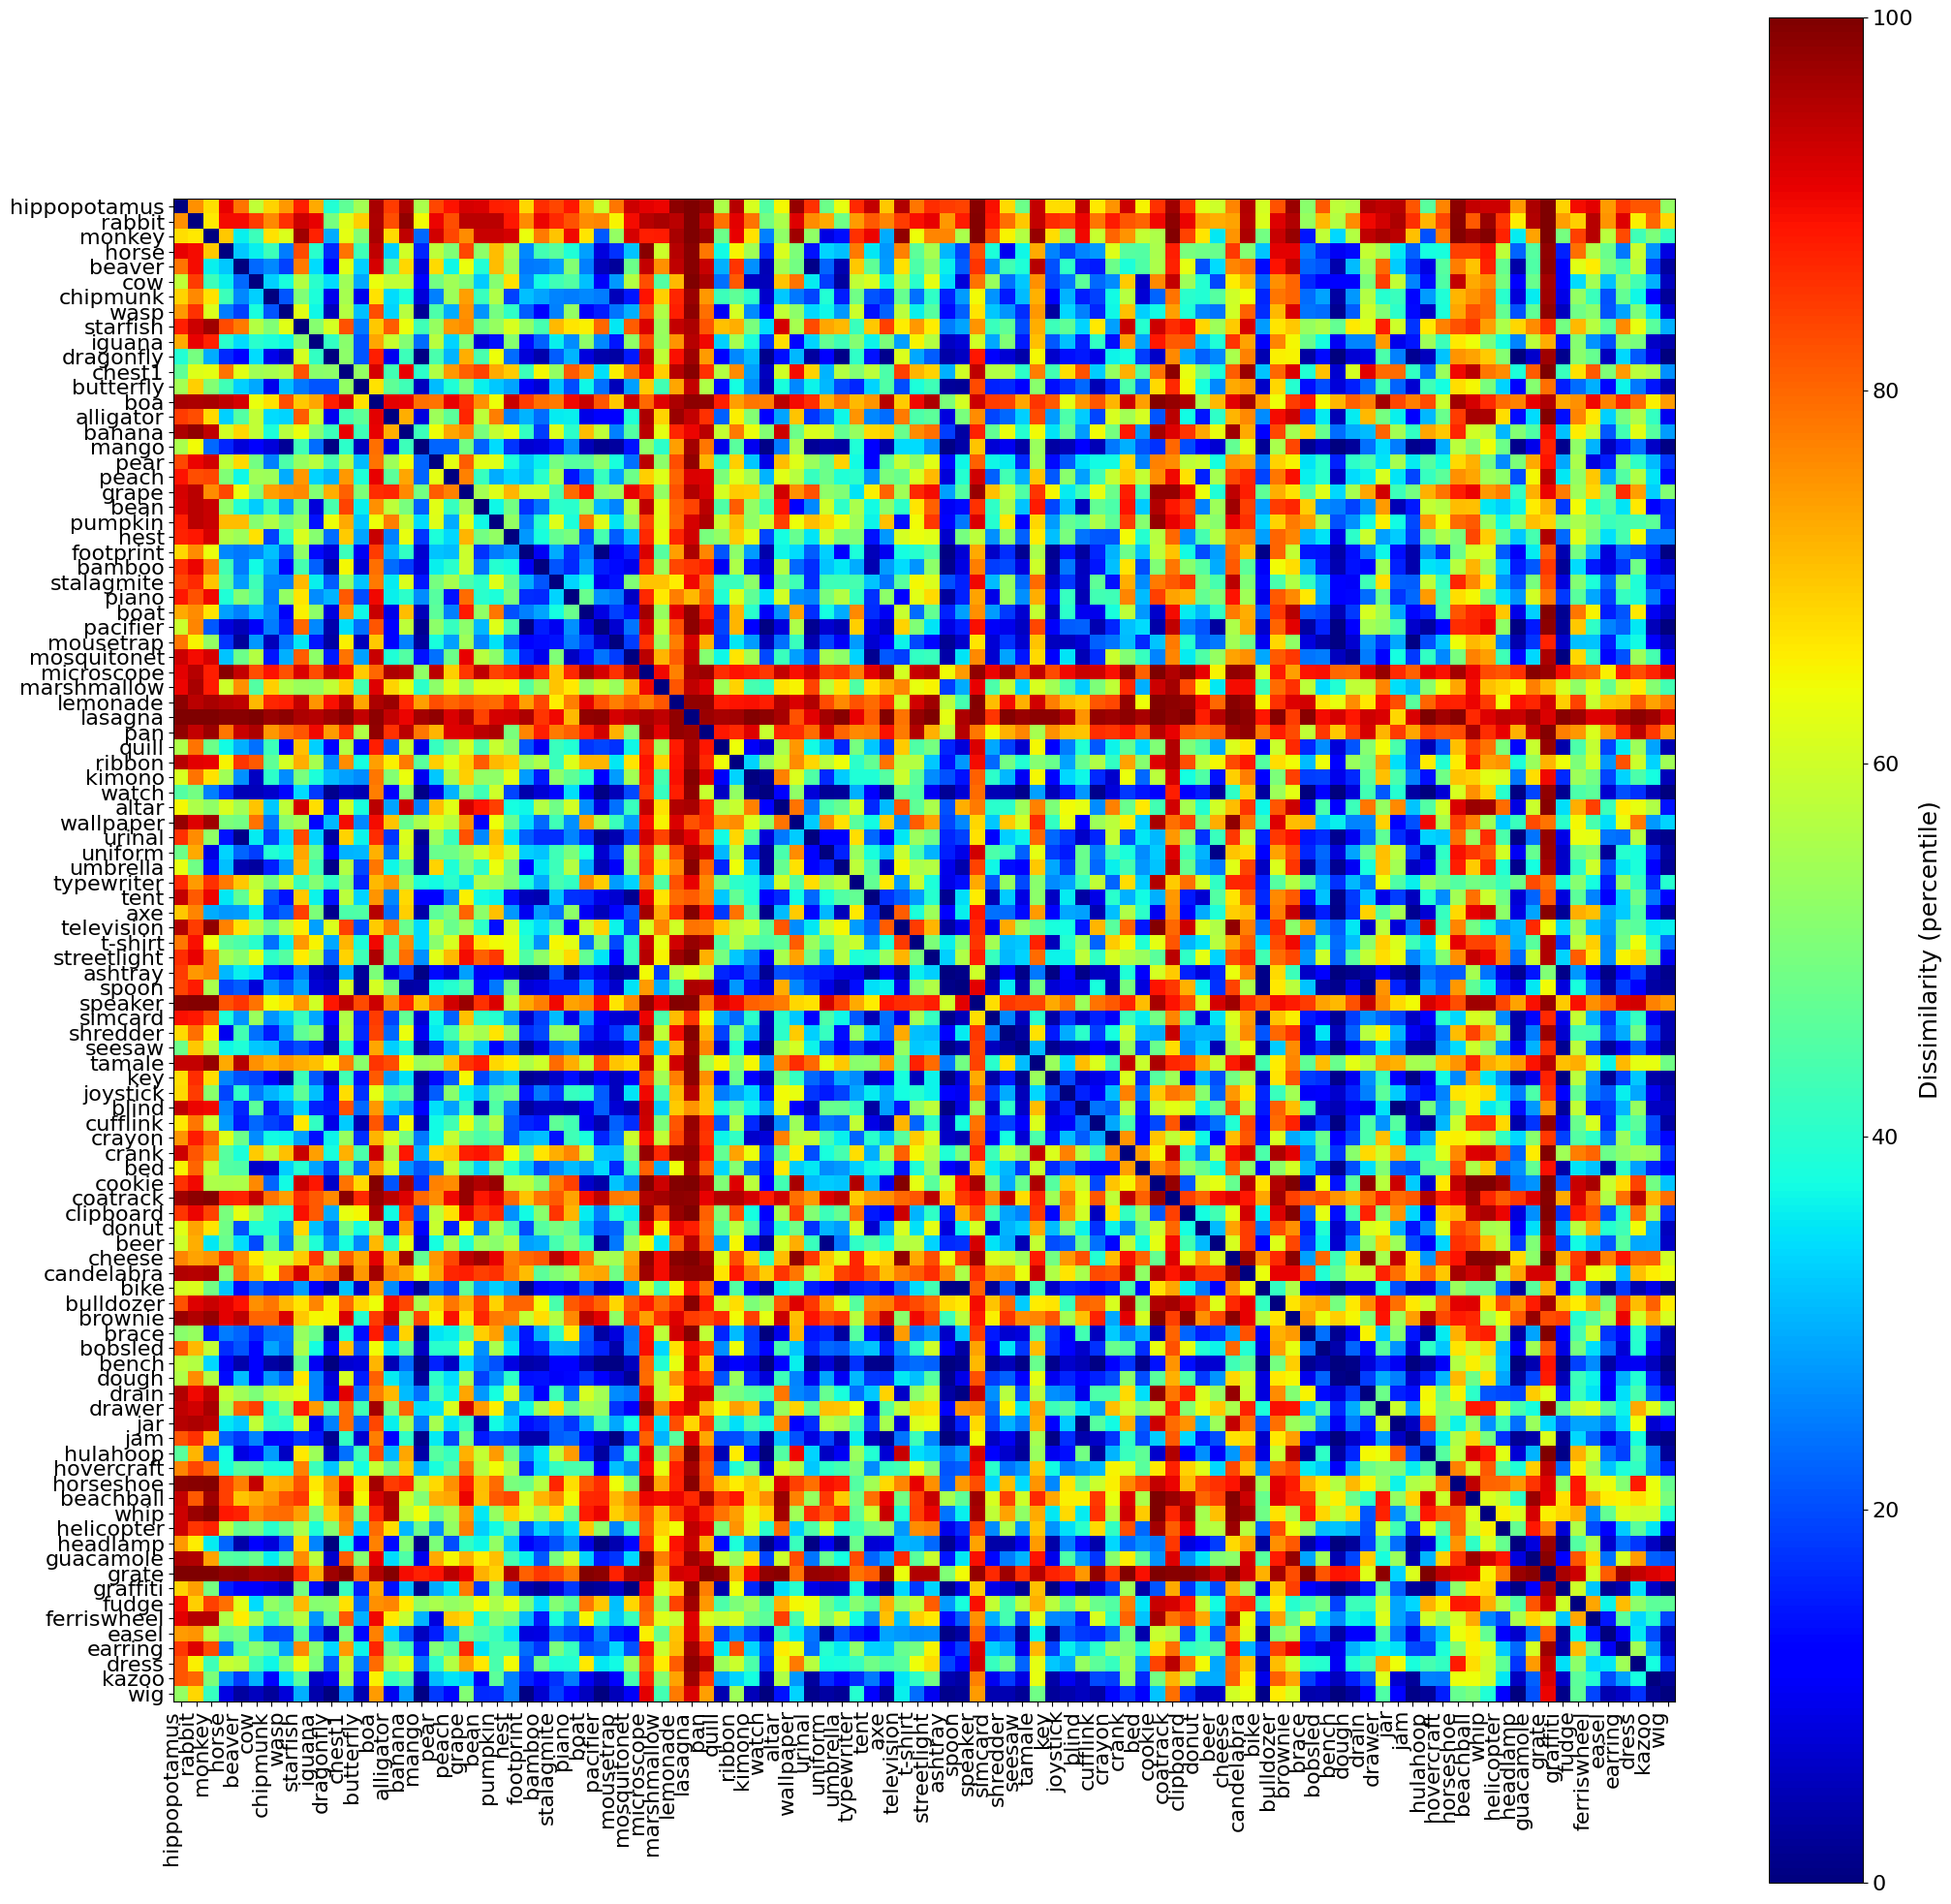

0

In [69]:
plt.figure(figsize=(25, 25))
questions_rdm = compute_rdm2(df_sorted_animacy['data'])

plot_rdm(questions_rdm, conditions = df_sorted_animacy['stimulus'], percentile = True )#

RDM for indoors distinction


Computing RDM

RDM computing finished!
1


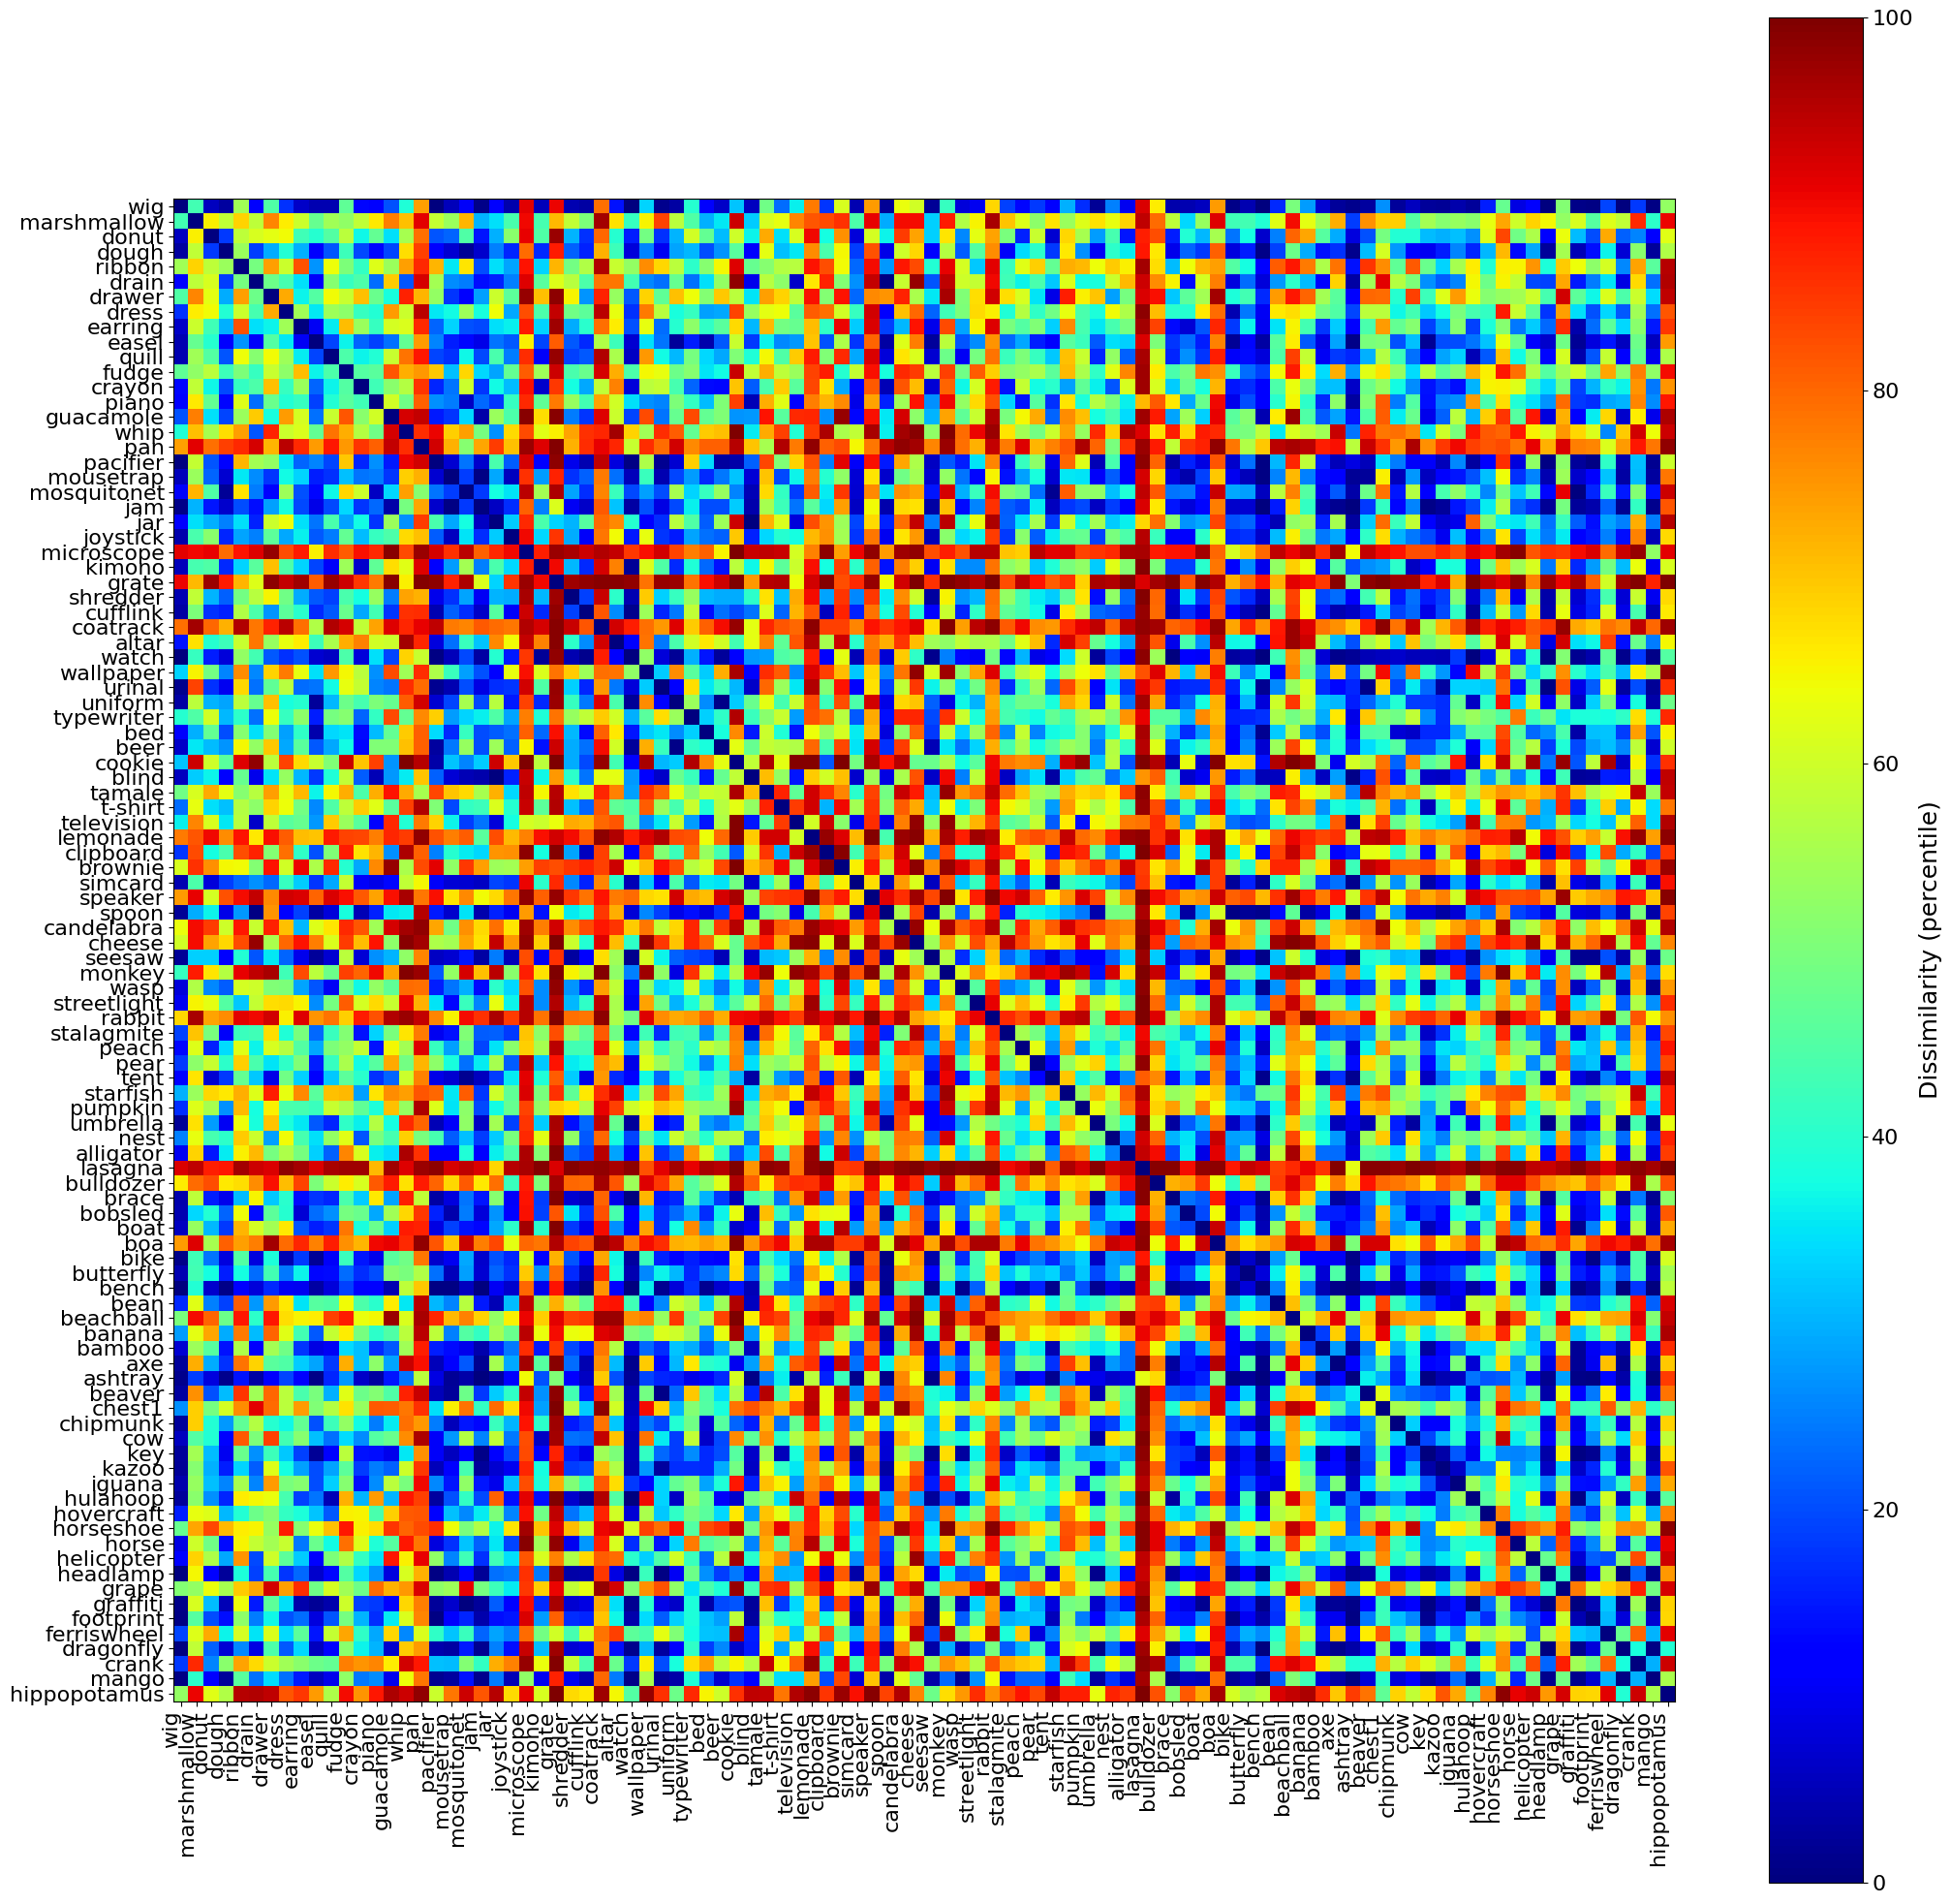

0

In [201]:

plt.figure(figsize=(25, 25))
questions_rdm = compute_rdm2(df_sorted_indoors['data'])

plot_rdm(questions_rdm, conditions = df_sorted_indoors['stimulus'], percentile = True )#